In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# Loading data

In [2]:
df_pro_contacts_adults = pd.read_csv("pro_contacts_adults.csv", index_col=0)
df_pro_contacts_children = pd.read_csv("pro_contacts_children.csv", index_col=0)
df_households = pd.read_csv("households.csv", index_col=0)


#infos
print(df_households.sum())
#df_households.describe()
#df_pro_contacts_children.describe()
#df_pro_contacts_adults.describe()




nb_children                                                 3085
nb_adults                                                   6960
type           two_parent_familytwo_parent_familytwo_parent_f...
size                                                       10045
dtype: object


# Initializing the graph

We start by defining the classes whose instances will be the nodes of our graph

In [3]:
class Person():
    def __init__(self, person_id, state, age):
        self.person_id = person_id
        self.age = age
        self.state = state
    def info(self):
        infos = "{} {} {}".format(self.age,self.person_id, self.state)
    
    def __str__(self):
        s = "Person #{}".format(self.person_id)
        return(s)
    
    def __repr__(self):
        s = "Person #{}".format(self.person_id)
        return(s)

class Adult(Person):
    def __init__(self, person_id, state, job_cat, pro_contacts, company_id):
        super().__init__(person_id, state, "adult")
        self.job_cat = job_cat
        self.pro_contacts = pro_contacts
        self.company_id = company_id
    def info(self):
        infos = "{} {} {}".format(self.age,self.person_id, self.state)

class Child(Person):
    def __init__(self, person_id, state, school_contacts, school_id):
        super().__init__(person_id, state, "child")
        self.job_cat = job_cat
        self.school_contacts = school_contacts
        self.school_id = school_id
    def info(self):
        infos = "{} {} {}".format(self.age,self.person_id, self.state)

We create an empty graph into which we add nodes from the pro_contacts dataframes.

In [4]:
G = nx.Graph()
people = [] # we'll store Person objects here too in order to be able to access them quickly with person_id

for i, row in df_pro_contacts_adults.iterrows(): #We add adults to the nodes
    person_id = row.adult_id
    state = "S"
    job_cat = row.job_cat
    pro_contacts = row.pro_contacts
    company_id = row.company_id
    
    adult_node = Adult(person_id, state, job_cat, pro_contacts, company_id)
    G.add_node(adult_node)
    people.append(adult_node)
    
for i, row in df_pro_contacts_children.iterrows(): #We add childrens to the nodes
    person_id = row.child_id
    state = "S"
    school_contacts = row.school_contacts
    school_id = row.school_id
    
    child_node = Child(person_id, state, school_contacts, school_id)
    G.add_node(child_node)
    people.append(child_node)

    #print(G.nodes())
    


# Creating cliques for households

In [5]:
n_households = max(max(df_pro_contacts_children.index), max(df_pro_contacts_adults.index))
for id_household in range(n_households):
    df_household_adults = df_pro_contacts_adults.loc[df_pro_contacts_adults.index == id_household]
    household_adults = df_household_adults.adult_id
    
    df_household_children = df_pro_contacts_children.loc[df_pro_contacts_children.index == id_household]
    household_children = df_household_children.child_id
    
    household_people_ids = list(household_children) + list(household_adults)
    for edge in combinations(household_people_ids, 2):
        a = people[edge[0]]
        b = people[edge[1]]
        G.add_edge(a, b)
        G[a][b]["type"] = "household"
        G[a][b]["id"] = id_household
        



In [6]:
if (False):
    #pos = nx.spring_layout(G, iterations=20)
    nx.draw_networkx_nodes(G,pos,node_size=30 ,alpha =0.3)
    nx.draw_networkx_edges(G, pos)
    

# Creating cliques for companies

In [7]:
n_companies = int(max(df_pro_contacts_adults.company_id))
for company_id in range(n_companies):
    df_company = df_pro_contacts_adults.loc[df_pro_contacts_adults.company_id == company_id]
    company_employees_ids = list(df_company.adult_id)
    
    for edge in combinations(company_employees_ids, 2):
        a = people[edge[0]]
        b = people[edge[1]]
        G.add_edge(a, b)
        G[a][b]["type"] = "company"
        G[a][b]["id"] = company_id

In [8]:
df_company

,adult_id,job_cat,pro_contacts,company_id
household_id,,,,
1087,2699,Services_other,1317,250.0
1619,4024,Services_other,201,250.0
2458,5009,Services_other,714,250.0


In [9]:
#calcule la position des nodes pour afficher le graph 
# /!\ très lent /!\
pos = nx.spring_layout(G, iterations=1)




C:\Users\nicol\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\nicol\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


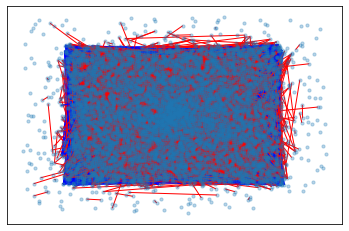

In [10]:
edge_color = []
for edge in G.edges():
    #print(edge)
    edge = G[edge[0]][edge[1]]
    if edge["type"] == "company":
        edge_color.append("b")
    if edge["type"] == "household":
        edge_color.append("r")
    

nx.draw_networkx_nodes(G,pos,node_size=10 ,alpha =0.3)
nx.draw_networkx_edges(G, pos,edge_color = edge_color)

# Adding links for pro life outside the company

In [11]:
for i, row in df_pro_contacts_adults.iterrows():
    adult_id = row.adult_id
    job_cat = row.job_cat
    pro_contacts = row.pro_contacts
    company_id = row.company_id
    
    company_employees_ids = list(df_pro_contacts_adults.loc[(df_pro_contacts_adults.company_id == company_id) &\
                                                            (df_pro_contacts_adults.adult_id != adult_id)].adult_id)

    #TO DO
        
for i, row in df_pro_contacts_children.iterrows():
    child_id = row.child_id
    school_contacts = row.school_contacts
    school_id = row.school_id
    
#     scool_pupils_ids = list(df_pro_contacts_children.loc[(df_pro_contacts_children.school_id == school_id) & (df_pro_contacts_adults.adult_id != adult_id)].adult_id)
    # TO DO

In [12]:
df_pro_contacts_adults.loc[(df_pro_contacts_adults.company_id == company_id)]

,adult_id,job_cat,pro_contacts,company_id
household_id,,,,
506,1245,Shops_other,9,101.0
745,1829,Services_other,998,101.0
1844,4395,Shops_other,4,101.0
3775,6933,Shops_other,13,101.0
3801,6959,Services_other,870,101.0


In [13]:
pro_contacts

870

# Exporting the graph for visualization with Gephi

In [14]:
nx.write_gexf(G, "test.gexf")

# Modeling Coronavirus behaviour without any action taken

### illness duration
https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30566-3/fulltext#seccestitle150 in this paper we see that in average an infected personne has symptomes for 20 days (worst and best being 8 days and 37 days). This is more or less independent of the fact that the individual recovers or die after thos 20 days. I will thus use this to calculate the half-life of the infected state. 

### infection probability
the R0 is given at 2.5. we calculate the probability of infecting a neighbor node using this and the mean duration of the infected state of 20 days. 




In [15]:
import numpy as np
# infected state duration and evolution
mean_sickness_duration = 20
half_life = mean_sickness_duration * np.log(2) 
daily_proba_change = 1 - (1/2)**(1/half_life) 

child_mortality = 0.002
adult_mortality = 0.02

child_recovery = 1- child_mortality
adult_recovery = 1- adult_mortality

mean_degree = len(G.edges) * 2 /len(G.nodes)
print(mean_degree)

#infection probability for each link daily
R0 = 2.5 
daily_infection_proba = R0 / mean_sickness_duration


26.066102538576406


In [16]:
"""model 1 SIR with permanent recovery nobody change their habits"""
import random 


class Basic_SIR_Model():
    
    def __init__(self,G):
        import random
        self.G = G # This model's graph
        
        self.states =["S" #sane
                ,"I" #infected
                ,"D" #dead
                ,"R"] #recovered
        
        #TODO remplacer tout ça par des vrais valeur 
        #infetion probabilyties are for each interactions everydays 
        #death and recovery proba are for one day
        
        
        mean_degree = len(self.G.edges) * 2 /len(self.G.nodes)
        daily_link_infection_proba = daily_infection_proba / mean_degree # this gives R0 = 2.5
        
        self.infection_probas=dict() #probability of infection dependeing on the type of the interaction
        self.infection_probas['company']= daily_link_infection_proba
        self.infection_probas["household"]= daily_link_infection_proba * 1.5 
        # because you spend more time with your family
        
        self.death_proba=dict() #daily proba of death if infected
        self.death_proba["adult"]= daily_proba_change * adult_mortality
        self.death_proba["child"]= daily_proba_change * child_mortality

        self.recovery_proba=dict() #daily proba of recovery if infected
        self.recovery_proba["adult"]= daily_proba_change * adult_recovery
        self.recovery_proba["child"]= daily_proba_change * child_recovery

        #TODO add a self.data = dict to get statistics 

    def initialize_patients_zero(self, number_of_first_cases = 1):
        for node in list(self.G.nodes()): # everybody is sane at the begining 
            node.state = "S"
        print('first infected are:') 
        for random_pick in random.sample(list(self.G.nodes()), number_of_first_cases): 
            print(random_pick)
            random_pick.state = "I"

    def interaction(self,interaction_type): # return true if there is an infection
        return ( random.random()<=self.infection_probas[interaction_type])

    def sickness_evolution(self,age): # return state of the infected at the end of the day
        r = random.random()
        if r <= self.death_proba[age]:
            return "D"
        if r<= self.recovery_proba[age]:
            return "R"
        else:
            return "I"

    def one_day_passes(self): #update all the graph 
        print("today everybody went to work as usual.")
        changing_state = dict()
        for state in self.states:
            changing_state[state]= []

        for node in list(self.G.nodes()):
            if node.state == "I":  
                #we try each possible infection
                for neig in self.G[node]: 
                    if neig.state == "S":
                        t = self.G[node][neig]['type']
                        if self.interaction(t):
                            changing_state["I"].append(neig) #new infected :'(         
                #we check if the condition of the sick change (death recovery or no change)
                new_state = self.sickness_evolution(node.age) 
                if new_state != node.state : 
                    changing_state[new_state].append(node)                    

        for state in self.states: #update all the nodes states at once after all the interactions
            for node in changing_state[state]:
                node.state = state

            #basic visualisation    kinda bad
            total =len([nd for nd in list(self.G.nodes) if nd.state == state ])
            print(state,' Total ',total, ' new',len(changing_state[state])," today") 
    
    def basic_scenario(self): 
        self.initialize_patients_zero(number_of_first_cases=5)
        for i in range(365):
            self.one_day_passes()


In [17]:
#We put 5 infected in a untouched country which take no counter-mesure for a year
m = Basic_SIR_Model(G)
m.basic_scenario()

first infected are:
Person #808
Person #921
Person #7719
Person #7993
Person #8937
today everybody went to work as usual.
S  Total  10040  new 0  today
I  Total  5  new 0  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usual.
S  Total  10040  new 0  today
I  Total  5  new 0  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usual.
S  Total  10040  new 0  today
I  Total  5  new 0  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usual.
S  Total  10040  new 0  today
I  Total  6  new 1  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usual.
S  Total  10039  new 0  today
I  Total  6  new 0  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usual.
S  Total  10039  new 0  today
I  Total  7  new 1  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usu

S  Total  8914  new 0  today
I  Total  687  new 44  today
D  Total  9  new 0  today
R  Total  509  new 31  today
today everybody went to work as usual.
S  Total  8871  new 0  today
I  Total  704  new 50  today
D  Total  10  new 1  today
R  Total  544  new 35  today
today everybody went to work as usual.
S  Total  8823  new 0  today
I  Total  727  new 62  today
D  Total  10  new 0  today
R  Total  578  new 34  today
today everybody went to work as usual.
S  Total  8764  new 0  today
I  Total  734  new 42  today
D  Total  11  new 1  today
R  Total  608  new 30  today
today everybody went to work as usual.
S  Total  8723  new 0  today
I  Total  758  new 56  today
D  Total  11  new 0  today
R  Total  637  new 29  today
today everybody went to work as usual.
S  Total  8668  new 0  today
I  Total  794  new 69  today
D  Total  11  new 0  today
R  Total  681  new 44  today
today everybody went to work as usual.
S  Total  8603  new 0  today
I  Total  797  new 48  today
D  Total  11  new 0  toda

S  Total  6429  new 0  today
I  Total  747  new 33  today
D  Total  49  new 0  today
R  Total  2884  new 31  today
today everybody went to work as usual.
S  Total  6396  new 0  today
I  Total  741  new 25  today
D  Total  50  new 1  today
R  Total  2923  new 39  today
today everybody went to work as usual.
S  Total  6371  new 0  today
I  Total  722  new 21  today
D  Total  51  new 1  today
R  Total  2948  new 25  today
today everybody went to work as usual.
S  Total  6350  new 0  today
I  Total  722  new 26  today
D  Total  51  new 0  today
R  Total  2979  new 31  today
today everybody went to work as usual.
S  Total  6324  new 0  today
I  Total  709  new 18  today
D  Total  51  new 0  today
R  Total  3012  new 33  today
today everybody went to work as usual.
S  Total  6306  new 0  today
I  Total  700  new 24  today
D  Total  51  new 0  today
R  Total  3045  new 33  today
today everybody went to work as usual.
S  Total  6282  new 0  today
I  Total  694  new 27  today
D  Total  52  new 

S  Total  5768  new 0  today
I  Total  47  new 1  today
D  Total  66  new 0  today
R  Total  4167  new 2  today
today everybody went to work as usual.
S  Total  5767  new 0  today
I  Total  46  new 1  today
D  Total  66  new 0  today
R  Total  4168  new 1  today
today everybody went to work as usual.
S  Total  5766  new 0  today
I  Total  45  new 0  today
D  Total  66  new 0  today
R  Total  4173  new 5  today
today everybody went to work as usual.
S  Total  5766  new 0  today
I  Total  41  new 1  today
D  Total  66  new 0  today
R  Total  4173  new 0  today
today everybody went to work as usual.
S  Total  5765  new 0  today
I  Total  43  new 2  today
D  Total  66  new 0  today
R  Total  4173  new 0  today
today everybody went to work as usual.
S  Total  5763  new 0  today
I  Total  43  new 0  today
D  Total  66  new 0  today
R  Total  4174  new 1  today
today everybody went to work as usual.
S  Total  5763  new 0  today
I  Total  47  new 5  today
D  Total  66  new 0  today
R  Total  4

I  Total  6  new 0  today
D  Total  67  new 0  today
R  Total  4231  new 2  today
today everybody went to work as usual.
S  Total  5743  new 0  today
I  Total  5  new 1  today
D  Total  67  new 0  today
R  Total  4231  new 0  today
today everybody went to work as usual.
S  Total  5742  new 0  today
I  Total  5  new 0  today
D  Total  67  new 0  today
R  Total  4232  new 1  today
today everybody went to work as usual.
S  Total  5742  new 0  today
I  Total  4  new 0  today
D  Total  67  new 0  today
R  Total  4232  new 0  today
today everybody went to work as usual.
S  Total  5742  new 0  today
I  Total  4  new 0  today
D  Total  67  new 0  today
R  Total  4232  new 0  today
today everybody went to work as usual.
S  Total  5742  new 0  today
I  Total  4  new 0  today
D  Total  67  new 0  today
R  Total  4232  new 0  today
today everybody went to work as usual.
S  Total  5742  new 0  today
I  Total  4  new 0  today
D  Total  67  new 0  today
R  Total  4233  new 1  today
today everybody we

## Basic counter-mesure

first I try something very basic and cruel: killing every infected I find. 
I suppose that the state take action once 200 people are infected. (time to discover there existence)
I suppose they can test everybody but with a technology that is not very reliable 0.3 chance to discover the virus and no false positive.
The results are not great at all, the virus still spreads but is now indirectly way worst

In [19]:
# we try to kill every infected once we discover them
class North_Korea(Basic_SIR_Model):
    def __init__(self,G):
        super().__init__(G)
        self.execution_proba = 0.3 #chance to be caught and executed if you are sick during a search
    
    def search(self):
        nb_killed = 0
        for node in list(self.G.nodes()):
            if(node.state == "I"): 
                r = random.random()
                if r < self.execution_proba: #we try to kill the infected quickly
                    node.state = "D"
                    nb_killed +=1
        print(nb_killed," killed during search")
    
    def basic_scenario(self): 
        self.initialize_patients_zero(number_of_first_cases=5)
        for i in range(365):
            self.one_day_passes()
            nb_infected = len([nd for nd in list(self.G.nodes) if nd.state == "I" ])   
            if nb_infected > 200 :
                m.search()
m = North_Korea(G)
m.basic_scenario()
"""m = North_Korea(G)
m.initialize_patients_zero(number_of_first_cases=5)
for i in range(365):
    m.one_day_passes()
    
    nb_infected = len([nd for nd in list(m.G.nodes) if nd.state == "I" ])   
    if nb_infected > 200 :
        m.search()
"""    

        
        

first infected are:
Person #6401
Person #1238
Person #9665
Person #1544
Person #5146
today everybody went to work as usual.
S  Total  10040  new 0  today
I  Total  6  new 1  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usual.
S  Total  10039  new 0  today
I  Total  8  new 2  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usual.
S  Total  10037  new 0  today
I  Total  9  new 1  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usual.
S  Total  10036  new 0  today
I  Total  12  new 3  today
D  Total  0  new 0  today
R  Total  1  new 1  today
today everybody went to work as usual.
S  Total  10033  new 0  today
I  Total  17  new 6  today
D  Total  0  new 0  today
R  Total  2  new 1  today
today everybody went to work as usual.
S  Total  10027  new 0  today
I  Total  23  new 7  today
D  Total  0  new 0  today
R  Total  4  new 2  today
today everybody went to work a

S  Total  9020  new 0  today
I  Total  156  new 10  today
D  Total  455  new 0  today
R  Total  434  new 10  today
today everybody went to work as usual.
S  Total  9010  new 0  today
I  Total  162  new 16  today
D  Total  456  new 1  today
R  Total  442  new 8  today
today everybody went to work as usual.
S  Total  8994  new 0  today
I  Total  170  new 17  today
D  Total  456  new 0  today
R  Total  454  new 12  today
today everybody went to work as usual.
S  Total  8977  new 0  today
I  Total  168  new 10  today
D  Total  456  new 0  today
R  Total  458  new 4  today
today everybody went to work as usual.
S  Total  8967  new 0  today
I  Total  179  new 16  today
D  Total  456  new 0  today
R  Total  466  new 8  today
today everybody went to work as usual.
S  Total  8952  new 0  today
I  Total  187  new 16  today
D  Total  456  new 0  today
R  Total  470  new 4  today
today everybody went to work as usual.
S  Total  8936  new 0  today
I  Total  196  new 13  today
D  Total  456  new 0  

S  Total  8347  new 0  today
I  Total  183  new 15  today
D  Total  643  new 0  today
R  Total  895  new 8  today
today everybody went to work as usual.
S  Total  8332  new 0  today
I  Total  182  new 7  today
D  Total  643  new 0  today
R  Total  907  new 12  today
today everybody went to work as usual.
S  Total  8325  new 0  today
I  Total  182  new 12  today
D  Total  643  new 0  today
R  Total  916  new 9  today
today everybody went to work as usual.
S  Total  8313  new 0  today
I  Total  188  new 16  today
D  Total  643  new 0  today
R  Total  928  new 12  today
today everybody went to work as usual.
S  Total  8298  new 0  today
I  Total  189  new 13  today
D  Total  643  new 0  today
R  Total  933  new 5  today
today everybody went to work as usual.
S  Total  8285  new 0  today
I  Total  203  new 22  today
D  Total  643  new 0  today
R  Total  941  new 8  today
today everybody went to work as usual.
S  Total  8266  new 0  today
I  Total  216  new 21  today
D  Total  643  new 0  t

S  Total  7466  new 0  today
I  Total  160  new 7  today
D  Total  986  new 0  today
R  Total  1447  new 7  today
today everybody went to work as usual.
S  Total  7459  new 0  today
I  Total  161  new 8  today
D  Total  986  new 0  today
R  Total  1455  new 8  today
today everybody went to work as usual.
S  Total  7451  new 0  today
I  Total  155  new 2  today
D  Total  986  new 0  today
R  Total  1458  new 3  today
today everybody went to work as usual.
S  Total  7449  new 0  today
I  Total  162  new 10  today
D  Total  986  new 0  today
R  Total  1463  new 5  today
today everybody went to work as usual.
S  Total  7439  new 0  today
I  Total  166  new 9  today
D  Total  986  new 0  today
R  Total  1472  new 9  today
today everybody went to work as usual.
S  Total  7430  new 0  today
I  Total  165  new 8  today
D  Total  987  new 1  today
R  Total  1480  new 8  today
today everybody went to work as usual.
S  Total  7422  new 0  today
I  Total  163  new 7  today
D  Total  987  new 0  to

today everybody went to work as usual.
S  Total  7163  new 0  today
I  Total  29  new 3  today
D  Total  992  new 0  today
R  Total  1865  new 1  today
today everybody went to work as usual.
S  Total  7160  new 0  today
I  Total  29  new 1  today
D  Total  992  new 0  today
R  Total  1866  new 1  today
today everybody went to work as usual.
S  Total  7159  new 0  today
I  Total  28  new 0  today
D  Total  992  new 0  today
R  Total  1866  new 0  today
today everybody went to work as usual.
S  Total  7159  new 0  today
I  Total  30  new 2  today
D  Total  992  new 0  today
R  Total  1867  new 1  today
today everybody went to work as usual.
S  Total  7157  new 0  today
I  Total  29  new 0  today
D  Total  992  new 0  today
R  Total  1868  new 1  today
today everybody went to work as usual.
S  Total  7157  new 0  today
I  Total  29  new 1  today
D  Total  992  new 0  today
R  Total  1869  new 1  today
today everybody went to work as usual.
S  Total  7156  new 0  today
I  Total  28  new 0 

D  Total  994  new 0  today
R  Total  1913  new 0  today
today everybody went to work as usual.
S  Total  7134  new 0  today
I  Total  4  new 0  today
D  Total  994  new 0  today
R  Total  1913  new 0  today
today everybody went to work as usual.
S  Total  7134  new 0  today
I  Total  4  new 0  today
D  Total  994  new 0  today
R  Total  1913  new 0  today
today everybody went to work as usual.
S  Total  7134  new 0  today
I  Total  4  new 0  today
D  Total  994  new 0  today
R  Total  1913  new 0  today
today everybody went to work as usual.
S  Total  7134  new 0  today
I  Total  4  new 0  today
D  Total  994  new 0  today
R  Total  1913  new 0  today
today everybody went to work as usual.
S  Total  7134  new 0  today
I  Total  5  new 1  today
D  Total  994  new 0  today
R  Total  1913  new 0  today
today everybody went to work as usual.
S  Total  7133  new 0  today
I  Total  5  new 0  today
D  Total  994  new 0  today
R  Total  1913  new 0  today
today everybody went to work as usual

'm = North_Korea(G)\nm.initialize_patients_zero(number_of_first_cases=5)\nfor i in range(365):\n    m.one_day_passes()\n    \n    nb_infected = len([nd for nd in list(m.G.nodes) if nd.state == "I" ])   \n    if nb_infected > 200 :\n        m.search()\n'